In [62]:
%reload_ext autoreload
%reload_ext line_profiler

In [63]:
%autoreload 2
from multiprocessing import Pool
import experiments

In [3]:
import pickle 
with open('resiqp.pkl', 'rb') as pkl:
    resiqp = pickle.load(pkl)

import pickle 
with open('reslog.pkl', 'rb') as pkl:
    reslog = pickle.load(pkl)

In [4]:
len(reslog[1]['width'])

100000

In [32]:
%time res1d = evaluate(bet_1d, alpha=0.05, ndata=100000, reps=10, wsq=10)

(100000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.1476, 'widthstd': 0.0073, 'widthlo': 0.1429, 'widthhi': 0.1522, 'ub': 0.6049, 'lb': 0.4573})
Wall time: 6.26 s


In [34]:
%time res2d = evaluate(bet_2d, alpha=0.05, ndata=100000, reps=10, wsq=10)

(100000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.0548, 'widthstd': 0.0069, 'widthlo': 0.0304, 'widthhi': 0.0811, 'ub': 0.5603, 'lb': 0.5055})
Wall time: 1min 18s


In [40]:
if __name__ ==  '__main__': 
    num_processors = 4
    p=Pool(processes = num_processors)
    output = p.starmap(experiments.width_experiment,[(10,wsq,tv) for wsq in (10,100) for tv in (0.05, 0.5)])
    print(output)

[None, None, None, None]


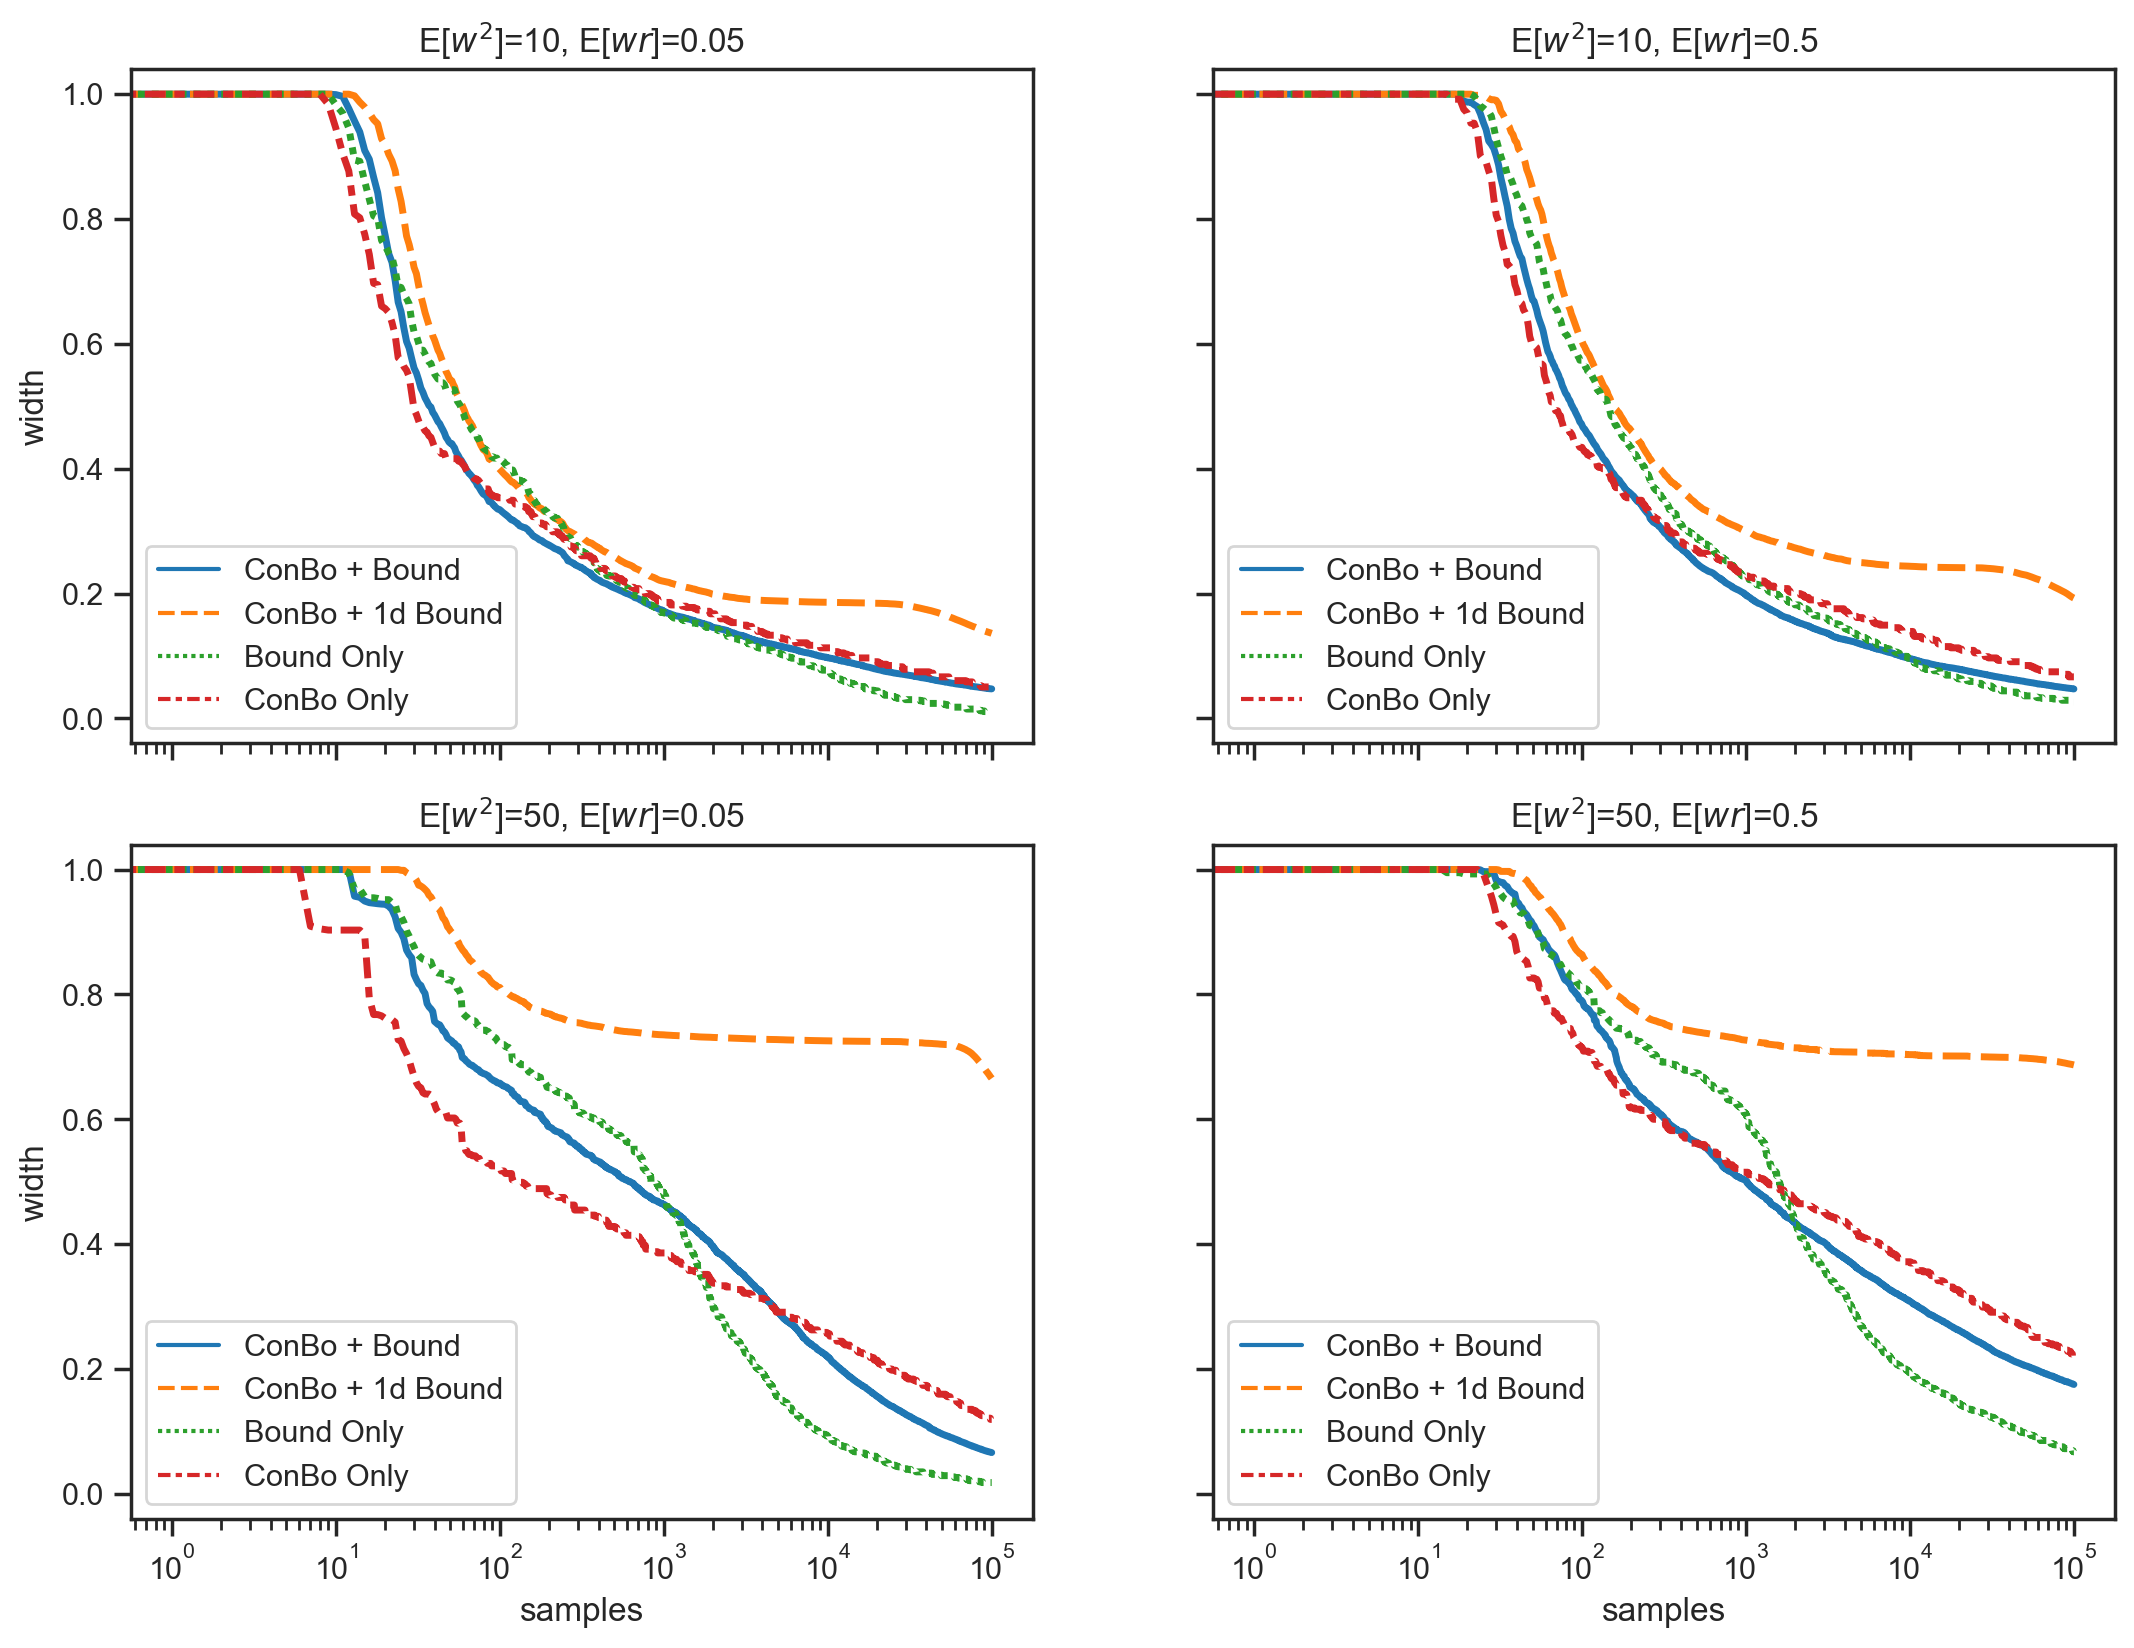

In [100]:
import pickle 
import os 
for root, folders, files  in os.walk('.'):
    pkls = [file for file in files if file.endswith('.pkl')]

legend = {'2d': 'ConBo + Bound', '1d': 'ConBo + 1d Bound', 'iqp': 'Bound Only', 'log': 'ConBo Only'}
fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(12.8, 9.6), dpi=200, gridspec_kw={'hspace': 0.15})
for i,wsq in enumerate((10, 50)):
    for j,tv in enumerate((0.05, 0.5)):
        d = {}
        for method in '2d','1d','iqp','log':
            name = f'width{method}_{wsq}_{tv}.pkl'
            with open(name, 'rb') as pkl:
                d[legend[method]] = pickle.load(pkl)[1]['width']
        experiments.plotit(d,f'E[$w^2$]={wsq}, E[$wr$]={tv}', ax=ax[i,j])
ax[0,0].set(xscale="log")
fig.savefig('width.pdf', bbox_inches='tight', pad_inches=0)

In [64]:
%matplotlib inline

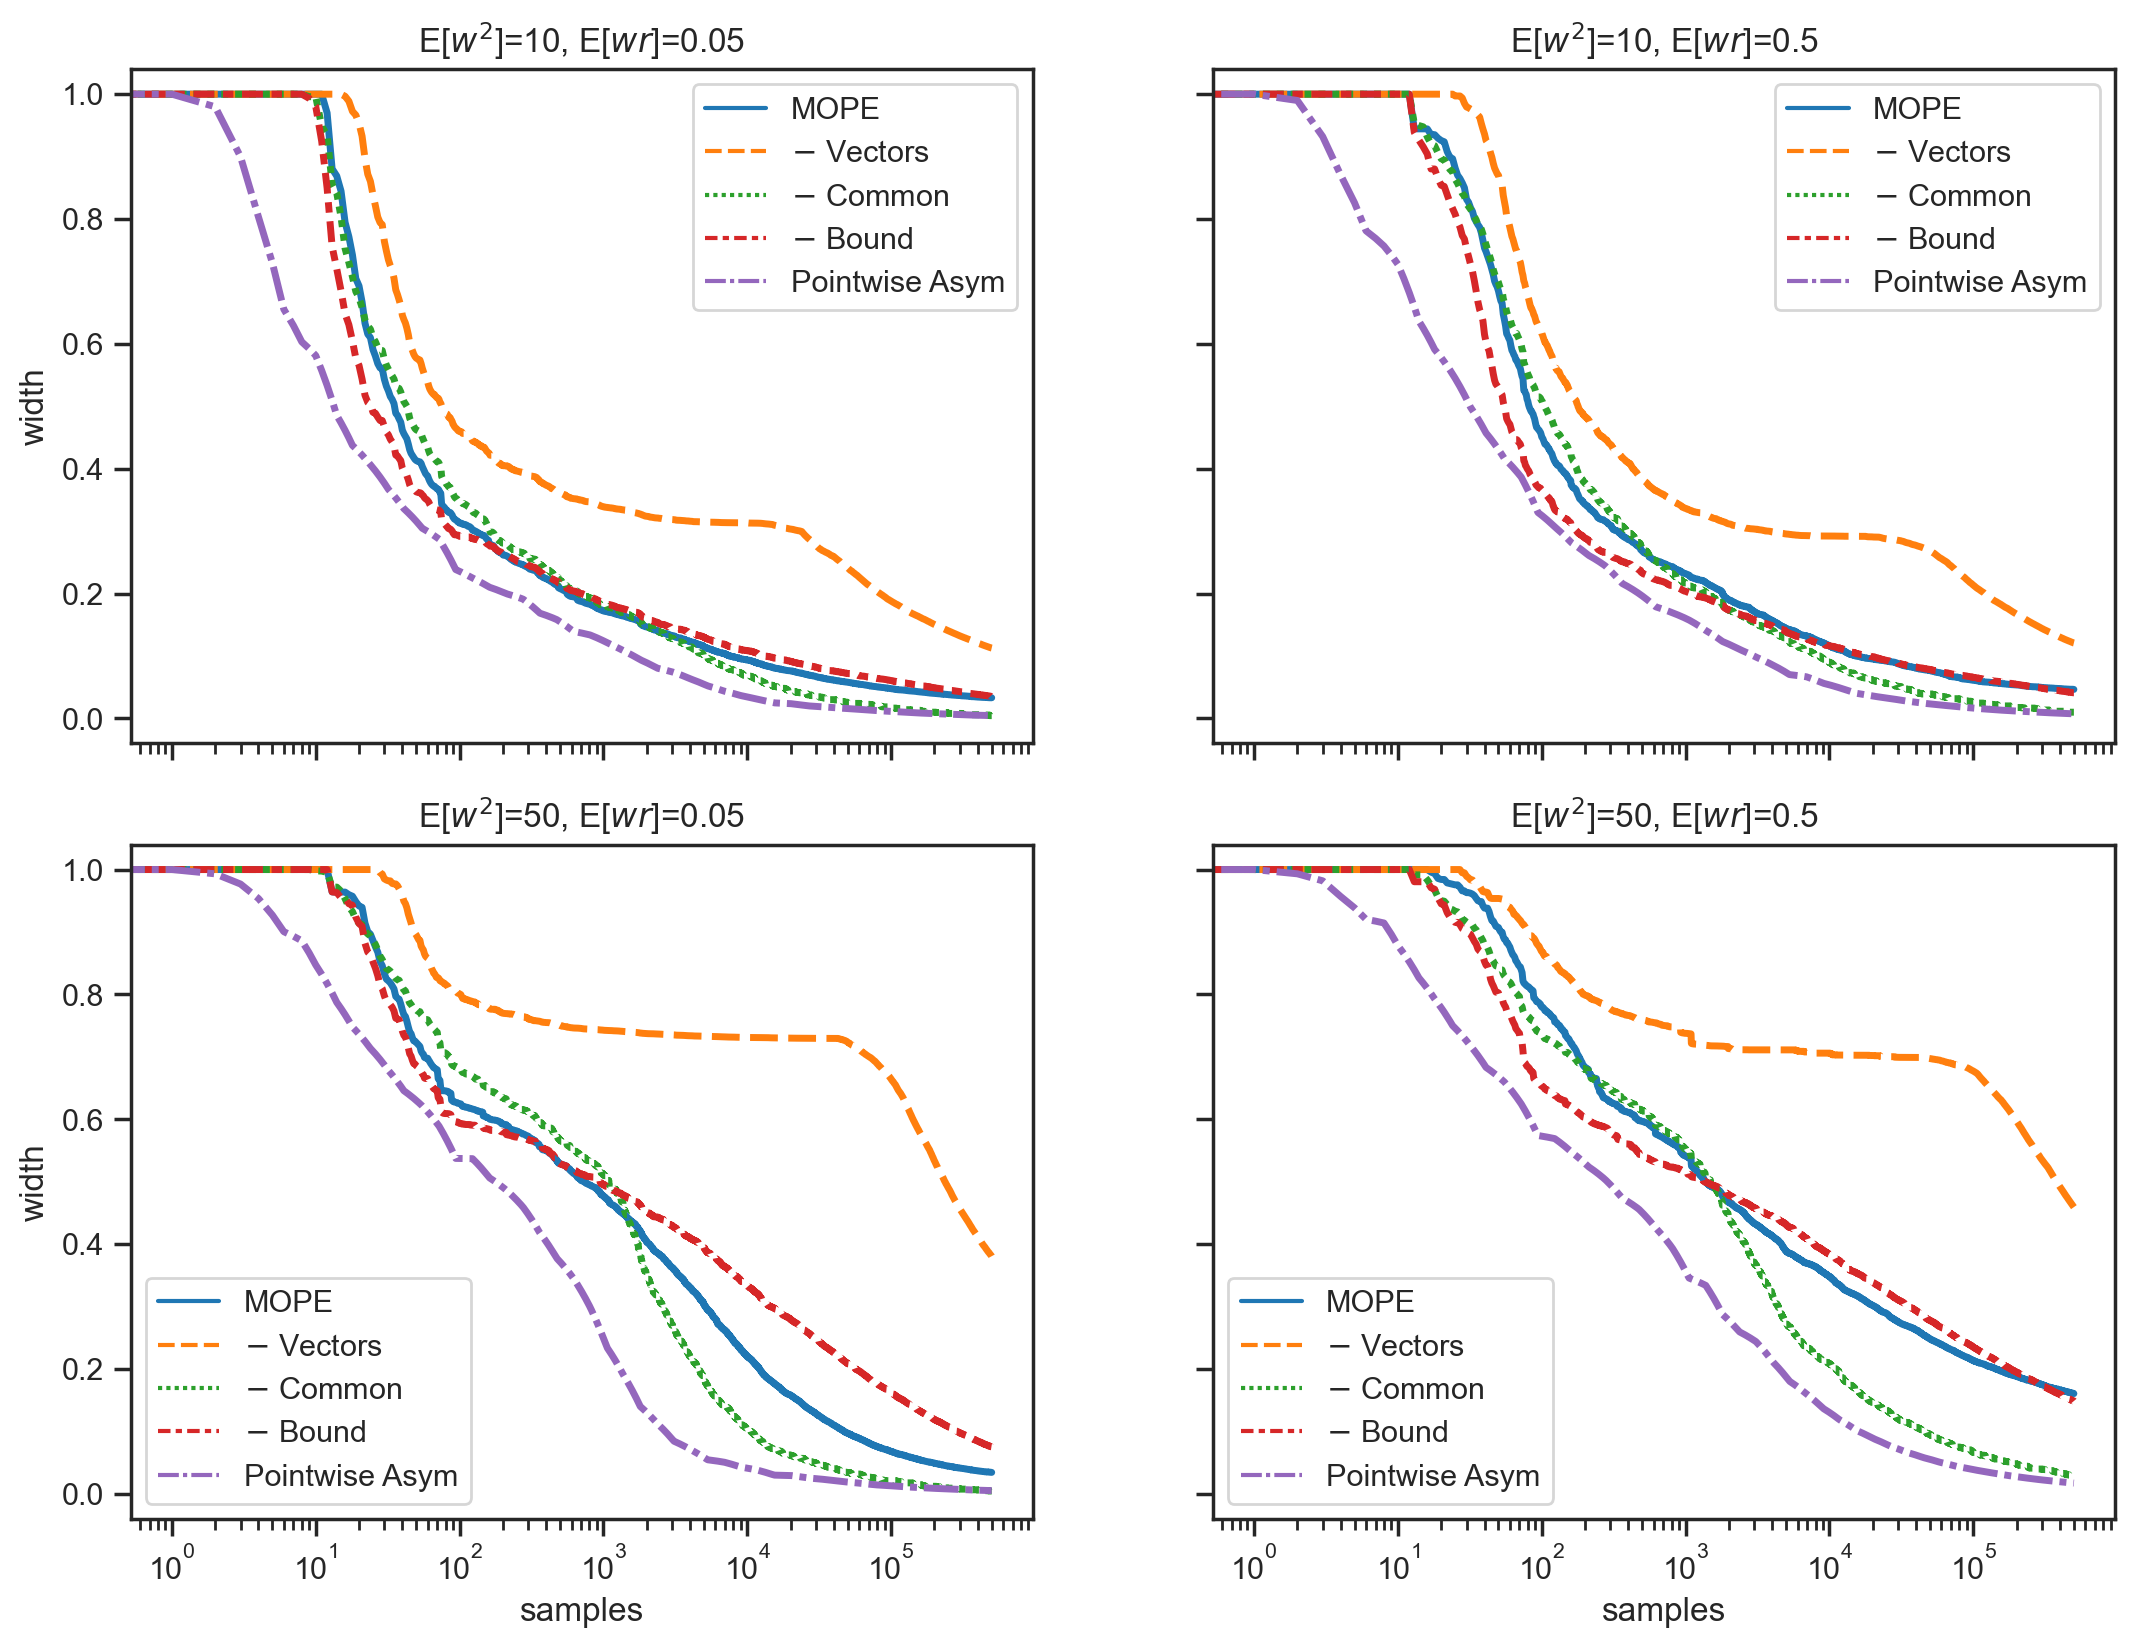

In [73]:
import pickle 
import os 
import matplotlib.pyplot as plt
import numpy as np
for root, folders, files  in os.walk('.'):
    pkls = [file for file in files if file.endswith('.pkl')]

legend = {'2d': 'MOPE', '1d': '$-$ Vectors', 'iqp': '$-$ Common', 'log': '$-$ Bound', 'pointasym': 'Pointwise Asym'}
fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(12.8, 9.6), dpi=200, gridspec_kw={'hspace': 0.15})
for i,wsq in enumerate((10, 50)):
    for j,tv in enumerate((0.05, 0.5)):
        d = {}
        for method in '2d','1d','iqp','log', 'pointasym':
            name = f'500k/width{method}_{wsq}_{tv}.pkl'
            with open(name, 'rb') as pkl:
                d[legend[method]] = pickle.load(pkl)[1]['width']
        experiments.plotit(d,f'E[$w^2$]={wsq}, E[$wr$]={tv}', ax=ax[i,j])
ax[0,0].set(xscale="log")
ax[0,1].set(xscale="log")
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
#t = 1+np.arange(500000.0)
#s0 = np.minimum(1,np.sqrt(.4975*np.log(t)/t))
#s1 = np.minimum(1,np.sqrt(4.75*np.log(t)/t))
#s2 = np.minimum(1,np.sqrt(2.4975*np.log(t)/t))
#s3 = np.minimum(1,np.sqrt(24.75*np.log(t)/t))
#ax[0,0].plot(t,s0,'k--')
#ax[0,0].plot(np.array([500000.0]),np.array([0.01109171218475567]),'ro')
#ax[0,1].plot(t,s1,'k--')
#ax[1,0].plot(t,s2,'k--')
#ax[1,1].plot(t,s3,'k--')
fig.savefig('width.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
from experiments import getenv
#env, env.getpw(), env.range(), env.expectedwsq()
env, pw, rng, ewsq = getenv(50., 0.05)
print(env, pw, rng, ewsq)
#V=E[w^2r^2]-E[wr]^2
sum(pw[0]*0.05*pw[1]**2)-0.05**2



<environments.ControlledRangeVariance.ControlledRangeVariance object at 0x00000229AF298508> (array([0.47110209, 0.36033221, 0.16364017, 0.00492554]), array([  0. ,   0.5,   2. , 100. ])) (0.0, 100.0) 49.99999997477571


2.497499998738786

In [38]:
np.var(z[1][:,0]*z[1][:,1])

0.3946524217657459

In [39]:
np.mean(z[1][:,0]*z[1][:,1])

0.05017388

In [ ]:
z = env.sample(1000000000)
np.var(z[1][:,0]*z[1][:,1])

In [19]:
experiments.evaluate_ci('asym', experiments.asym_ci, alpha=0.05, ndata=100000, reps=100, wsq=10, tv=0.05)

(100000, {'cov': 0.92, 'covstd': 0.0274, 'ubcov': 0.95, 'lbcov': 0.97, 'final_width': 0.0111, 'widthstd': 0.0005, 'widthlo': 0.0034, 'widthhi': 0.0188, 'ub': 0.0563, 'lb': 0.0452})


(100000,
 {'cov': 0.92,
  'covstd': 0.0274033534671728,
  'width': 0.01109171218475567,
  'widtstd': 0.0005154983611335916})

In [57]:
%time ours = experiments.evaluate('nonasym', experiments.bet_2d, alpha=0.05, ndata=100000, reps=20, wsq=10, tv=0.05)

(100000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.0474, 'widthstd': 0.0024, 'widthlo': 0.0317, 'widthhi': 0.0626, 'ub': 0.0734, 'lb': 0.026})
Wall time: 2min 27s


In [69]:
from functools import partial
asym_cs = partial(experiments.asym_cs_union, adjust=False)
for wsq in 10, 50:
    for tv in 0.05, 0.5:
        asym_no_union = experiments.evaluate(f'500k/widthpointasym_{wsq}_{tv}.pkl', asym_cs, alpha=0.05, ndata=500000, reps=10, wsq=wsq, tv=tv)
        print(asym_no_union)
#asym_union = experiments.evaluate('union', experiments.asym_cs_union, alpha=0.05, ndata=100000, reps=20, wsq=10, tv=0.05)

(500000, {'cov': 0.9, 'covstd': 0.1054, 'ubcov': 1.0, 'lbcov': 0.9, 'final_width': 0.0046, 'widthstd': 0.0006, 'widthlo': 0.0025, 'widthhi': 0.0079, 'ub': 0.0525, 'lb': 0.0479})
(500000, {'cov': array([1. , 1. , 1. , ..., 0.9, 0.9, 0.9]), 'covstd': array([0.        , 0.        , 0.        , ..., 0.10540926, 0.10540926,
       0.10540926]), 'width': array([1.        , 1.00001117, 0.97982913, ..., 0.00461972, 0.00461971,
       0.00461971]), 'widtstd': array([0.00000000e+00, 1.05427445e-06, 7.33361467e-03, ...,
       6.46473706e-04, 6.46472953e-04, 6.46472201e-04])})
(500000, {'cov': 0.9, 'covstd': 0.1054, 'ubcov': 0.9, 'lbcov': 1.0, 'final_width': 0.0074, 'widthstd': 0.0004, 'widthlo': 0.0056, 'widthhi': 0.0087, 'ub': 0.503, 'lb': 0.4956})
(500000, {'cov': array([1. , 1. , 1. , ..., 0.9, 0.9, 0.9]), 'covstd': array([0.        , 0.        , 0.        , ..., 0.10540926, 0.10540926,
       0.10540926]), 'width': array([1.        , 1.00001312, 0.98990629, ..., 0.00742602, 0.00742601,
     

[None]

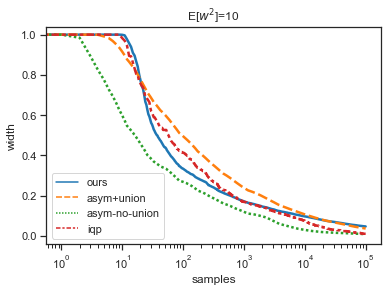

In [61]:
#d={}
fig, ax = plt.subplots()
d['ours'] = ours[1]['width']
d['asym+union'] = asym_union[1]['width']
d['asym-no-union'] = asym_no_union[1]['width']
experiments.plotit(d,f'E[$w^2$]=10', ax=ax)
ax.set(xscale="log")
#fig.savefig('width.pdf', bbox_inches='tight', pad_inches=0)

In [44]:
asym_union

(100000,
 {'cov': array([1., 1., 1., ..., 1., 1., 1.]),
  'covstd': array([0., 0., 0., ..., 0., 0., 0.]),
  'width': array([1.        , 1.0000104 , 1.00001142, ..., 0.31643745, 0.31643744,
         0.31643744]),
  'widtstd': array([0.00000000e+00, 6.82406943e-07, 6.49453278e-07, ...,
         8.56293352e-04, 8.56291688e-04, 8.56290023e-04])})

In [60]:
with open('widthiqp_10_0.05.pkl', 'rb') as pkl:
    d['iqp'] = pickle.load(pkl)[1]['width']